## Resolved photometric catalog of CANDELS Galaxies given RA,DEC
last updated: May 1st, 2019 by Shooby

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import convolve, convolve_fft
from photutils import create_matching_kernel
from scipy import ndimage



In [3]:
## Revise all a) the addresses to the science and rms images and b) the file names for the filters 
## that are observed in your field as well as the c) zero points of observations before running.

imdir_south = '/Volumes/Hasan/resolved/GOODS-S/30mas/'

def drzname(filt):
    if filt=='u1':
        fn=imdir_south+'atoh.fits'
    if filt=='u2':
        fn=imdir_south+'wtoh.fits'
    if filt=='u3':
        fn=imdir_south+'utoh.fits'
    if filt=='b':
        fn=imdir_south+'goodss_all_acs_wfc_f435w_030mas_v1.5_drz.fits'
    if filt=='v':
        fn=imdir_south+'goodss_all_acs_wfc_f606w_030mas_v1.5_drz.fits'
    if filt=='i':
        fn=imdir_south+'goodss_all_acs_wfc_f775w_030mas_v1.5_drz.fits'
    if filt=='i2':
        fn=imdir_south+'goodss_all_acs_wfc_f814w_030mas_v1.5_drz.fits'
    if filt=='z':
        fn=imdir_south+'goodss_all_acs_wfc_f850l_030mas_v1.5_drz.fits'
    if filt=='y':
        fn=imdir_south+'gs_all_candels_udf_wfc3_f105w_030mas_v1.0_drz.fits'
    if filt=='j':
        fn=imdir_south+'gs_all_candels_udf_wfc3_f125w_030mas_v1.0_drz.fits'
    if filt=='h':
        fn=imdir_south+'gs_all_candels_ers_udf_wfc3_f160w_030mas_v1.0_drz.fits'
    return fn

def rmsname(filt):
    if filt=='b':
        fn=imdir_south+'goodss_all_acs_wfc_f435w_030mas_v1.5_rms.fits'
    if filt=='v':
        fn=imdir_south+'goodss_all_acs_wfc_f606w_030mas_v1.5_rms.fits'
    if filt=='i':
        fn=imdir_south+'goodss_all_acs_wfc_f775w_030mas_v1.5_rms.fits'
    if filt=='z':
        fn=imdir_south+'goodss_all_acs_wfc_f850l_030mas_v1.5_rms.fits'
    if filt=='y':
        fn=imdir_south+'gs_all_candels_udf_wfc3_f105w_030mas_v1.0_rms.fits'
    if filt=='j':
        fn=imdir_south+'gs_all_candels_udf_wfc3_f125w_030mas_v1.0_rms.fits'
    if filt=='h':
        fn=imdir_south+'gs_all_candels_ers_udf_wfc3_f160w_030mas_v1.0_rms.fits'
    return fn

#zero points
u1zp,u2zp,u3zp,bzp,vzp,izp,zzp,yzp,jzp,hzp=24.040,24.130,24.668,25.673,26.486,25.654,24.862,26.2687,26.2303,25.9463

def fluxtomag(f,rms,zp):
    m=-99.0
    rm=-99.0
    if f > 0 : 
        m=-2.5*np.log10(f)+zp
        rm=1.085736*(rms/f)
    if rm ==0:
        rm=0.5
    return m,rm

In [9]:
def radec2xy(ra,dec,wc):
    coords = SkyCoord(ra,dec, unit='deg')
    a=wcs.utils.skycoord_to_pixel(coords, wc, origin=0,mode=u'wcs')
    return a[0],a[1]
    
def cut(ra,dec,andaze,filename):
    '''gets coordinates of the galaxy and the filter to return a cutout
    (also called a postage stamp) of the galaxy with given size'''
    hdr = pyfits.getheader(filename)
    w = wcs.WCS(hdr)
    x,y=radec2xy(ra,dec,w)
    x,y=np.int(x),np.int(y)
    im=pyfits.getdata(filename)[y-andaze:y+andaze,x-andaze:x+andaze]
    
    return im

def psfmatched_smallcut(ra,dec,filt,field='S',s=30):
    '''This function will use the PSFs of the higher resolution (shorter wavelength filter
    and the lowest resolution (h-band) and makes a kernel from the two which is then convolved
    with each 100x100 image to match the resolution to H-band image and then a smaller cut
    is returned.'''
    
    psf_dir = '/Volumes/Hasan/work/GOODS/mypsf/'

    image = cut(ra,dec,100,drzname(filt))
    psfh = pyfits.getdata(psf_dir+"psf_h.fits")
    psffilt = pyfits.getdata(psf_dir+"psf_"+str(filt)+".fits")
    kernel = create_matching_kernel(psffilt,psfh)
    result = convolve(image, kernel)
    im=result[100-s:100+s,100-s:100+s]
    
    dummy=dec
    rm = cut(ra,dec,100,rmsname(filt))
    rm = convolve(rm, kernel)
    rms = rm[100-s:100+s,100-s:100+s]
    return im,rms

def segment(a1,above_mean=1.25,add_image_back=0.5,random_noise=0.2):
    '''Returns segmentation of an image by some filtering of lower level 
    noises, to restrict the fitting to the galaxy itself and mask the 
    surroundings'''
    im2=ndimage.gaussian_filter(a1, 2)
    mask = (im2 > above_mean*im2.mean()).astype(np.float)
    mask += add_image_back * im2
    img = mask + random_noise*np.random.randn(*mask.shape)
    hist, bin_edges = np.histogram(img, bins=60)
    bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    binary_im = img > random_noise
    open_img = ndimage.binary_opening(binary_im)
    close_img = ndimage.binary_closing(open_img)
    return close_img

def make_catalog(ra,dec,specz):
    '''Make a small cutout (60x60) around galaxy in each filter, PSFmatch to H band, multiply by
    segmentation map and write to a file.'''
    b,rmsb=psfmatched_smallcut(ra,dec,'b')
    v,rmsv=psfmatched_smallcut(ra,dec,'v')
    i,rmsi=psfmatched_smallcut(ra,dec,'i')
    z,rmsz=psfmatched_smallcut(ra,dec,'z')
    y,rmsy=psfmatched_smallcut(ra,dec,'y')
    j,rmsj=psfmatched_smallcut(ra,dec,'j')
    h,rmsh=psfmatched_smallcut(ra,dec,'h')
    seg=segment(h)
    fil=open('galcat/gal_'+str(ra)+str(dec)+'.cat','w+')
    idd=0
    #plt.imshow(seg*h,origin='lower')
    for p in np.arange(0,np.shape(b)[0]):
        for q in np.arange(0,np.shape(b)[1]):
            if seg[p,q]==True:               
                bm,rms_bm=fluxtomag(b[p,q],rmsb[p,q],bzp)
                vm,rms_vm=fluxtomag(v[p,q],rmsv[p,q],vzp)
                im,rms_im=fluxtomag(i[p,q],rmsi[p,q],izp)
                zm,rms_zm=fluxtomag(z[p,q],rmsz[p,q],zzp)
                ym,rms_ym=fluxtomag(y[p,q],rmsy[p,q],yzp)
                jm,rms_jm=fluxtomag(j[p,q],rmsj[p,q],jzp)
                hm,rms_hm=fluxtomag(h[p,q],rmsh[p,q],hzp)
                fil.write(str(idd)+'\t'+str(bm)+'\t'+str(rms_bm)+'\t'+str(vm)+'\t'+str(rms_vm)+'\t'+str(im)+'\t'+
                          str(rms_im)+'\t'+str(zm)+'\t'+str(rms_zm)+'\t'+str(ym)+'\t'+str(rms_ym)+'\t'+str(jm)+'\t'+
                          str(rms_jm)+'\t'+str(hm)+'\t'+str(rms_hm)+'\t'+'1023'+'\t'+str(specz)+'\n')
            idd+=1
    fil.close()
    return seg

In [10]:
ra,dec,redshift = 53.221685648719514,-27.822356079959807,1.0

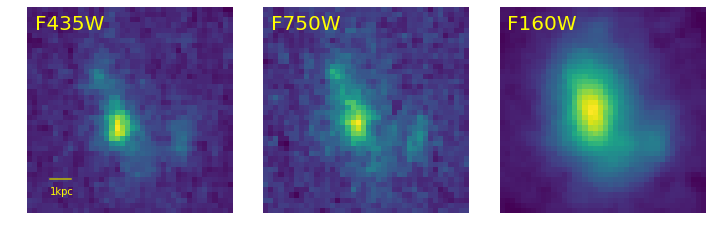

In [13]:
## this is just looking at small (40x40) cutouts around RA,DEC 

b=cut(ra,dec,20,drzname('b'))
i=cut(ra,dec,20,drzname('i'))
h=cut(ra,dec,20,drzname('h'))


plt.figure(figsize=(10,6))
plt.subplot(1,3,1)
plt.imshow(b,origin='lower')
plt.plot([4,8],[6,6],'y-')
plt.text(4,3,'1kpc',color='yellow')
plt.axis('off')
plt.text(1,35,'F435W',color='yellow',size=20)

plt.subplot(1,3,2)
plt.imshow(i,origin='lower')
plt.axis('off')
plt.text(1,35,'F750W',color='yellow',size=20)

plt.subplot(1,3,3)
plt.imshow(h,origin='lower')
plt.axis('off')
plt.text(1,35,'F160W',color='yellow',size=20)

plt.tight_layout()

In [14]:
seg = make_catalog(ra,dec,redshift)

In [ ]:
## To write in format readable by LePhare SED fitting code
f=open('sedfit.sh','w+')
for i in range(len(gj[:,1])):
    ra,dec=gj[i,1],gj[i,2]
    f.write('$LEPHAREDIR/source/zphota -CAT_IN galcat/gal_'+str(ra)+str(dec)+'.cat -CAT_OUT sedfit/gal_'+str(ra)+str(dec)+'.out -c zphot.para'+'\n')
    
f.close()    